# HFSsizing actor notes

In [6]:
using Revise
using FUSE
using IMAS
using Plots;
FUSE.logging(Logging.Info; actors=Logging.Debug);

## Make new FPP equilibirum from scratch

### Initialize from FPP v1_demount

In [7]:
dd = IMAS.dd()
ini, act = FUSE.case_parameters(:FPP, version=:v1_demount, init_from=:scalars);

### Modify ini

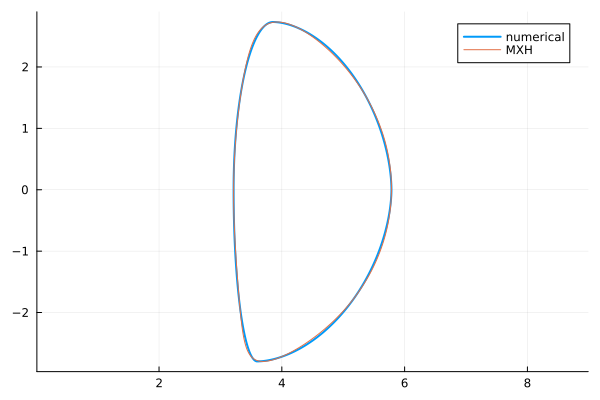

R0: 4.500048955128302
Z0: -0.03214285714285703
ϵ: 0.28570029868693425
κ: 2.1500818669706243
c0: 0.056608604065974386
c: [-0.0009888206695436725, -0.045855247198219, 0.01083490910069099, 0.004952046910889266]
s: [0.5194090641346907, 0.020207963121815355, -0.05255649829528511, 0.008936886380633717]


172800.0

In [8]:
ini.equilibrium.R0 = missing # 5.0
ini.equilibrium.B0 = 6.0
ini.equilibrium.ip = 8.75e6
ini.equilibrium.ϵ = missing # 1/3.5
ini.equilibrium.κ = missing # 2.1
ini.equilibrium.δ = missing # 0.6
ini.equilibrium.ζ = 0.0
ini.equilibrium.pressure_core = 1.5e6

ini.build.layers[:hfs_vacuum_vessel] += ini.build.layers[:hfs_vacuum_vessel_wall_inner] + ini.build.layers[:hfs_vacuum_vessel_wall_outer]
delete!(ini.build.layers,:hfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:hfs_vacuum_vessel_wall_outer)
ini.build.layers[:lfs_vacuum_vessel] += ini.build.layers[:lfs_vacuum_vessel_wall_inner] + ini.build.layers[:lfs_vacuum_vessel_wall_outer]
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_outer)

mhx_order = 4
R0 = 4.5
eps = 1/3.5
a = R0*eps
kapu = 2.125
kapl = 2.175
delu = 0.5
dell = 0.7
zetaou = -0.1
zetaol = -0.0
zetaiu = -0.0
zetail = -0.1
upnull = false
lonull = false

r, z, zref = try
    IMAS.boundary_shape(; a, eps, kapu, kapl, delu, dell, zetaou, zetaiu, zetaol, zetail, zoffset=0.0, upnull, lonull)
catch e
    [NaN], [NaN], [NaN]
end

mxh = IMAS.MXH(r, z, mhx_order)
mxh_vect = IMAS.flat_coeffs(mxh)

plot(r, z; aspect_ratio=:equal, lw=2, label="numerical")
display(plot!(mxh,label="MXH"))
display(mxh)

ini.core_profiles.impurity = :Kr
ini.core_profiles.n_shaping = 2.5
ini.core_profiles.T_shaping = 2.5
ini.core_profiles.T_ratio = 0.825
ini.core_profiles.greenwald_fraction = 1.0
ini.core_profiles.ne_ped = missing
ini.core_profiles.greenwald_fraction_ped = 0.67
ini.core_profiles.helium_fraction = 0.04


ini.equilibrium.boundary_from = :MXH_params
ini.equilibrium.MXH_params = mxh_vect
ini.equilibrium.field_null_surface = 0.8
ini.equilibrium.xpoints = :lower

ini.build.plasma_gap = 0.125
ini.build.divertors = :lower
ini.build.symmetric = false

ini.ec_launchers.power_launched = 25e6

ini.pf_active.n_coils_outside = 8

ini.requirements.flattop_duration = 48*3600.0

In [9]:
RiPlasma = R0 - a
ϵ = a/R0

# HFS layers

ini.build.layers[:plasma] = 2*a*(1+ini.build.plasma_gap)
ini.build.layers[:hfs_first_wall] = 0.02
ini.build.layers[:hfs_blanket] = 0.55*((1/ϵ-1.8)/2.2)^0.5
ini.build.layers[:hfs_high_temp_shield] = RiPlasma*0.05
ini.build.layers[:hfs_gap_high_temp_shield_vacuum_vessel] = RiPlasma * 0.02
ini.build.layers[:hfs_vacuum_vessel] = RiPlasma * 0.05
ini.build.layers[:hfs_gap_vacuum_vessel_low_temp_shield] = RiPlasma * 0.02
ini.build.layers[:hfs_low_temp_shield] = 0.45-0.15*((1/ϵ-1.8)/2.2)^0.5
ini.build.layers[:hfs_gap_low_temp_shield_TF] = RiPlasma * 0.02

rbCenterPost = (R0 - 0.5*ini.build.layers[:plasma] - ini.build.layers[:hfs_first_wall] - ini.build.layers[:hfs_blanket]
    - ini.build.layers[:hfs_high_temp_shield] - ini.build.layers[:hfs_gap_high_temp_shield_vacuum_vessel]
    - ini.build.layers[:hfs_vacuum_vessel] - ini.build.layers[:hfs_gap_vacuum_vessel_low_temp_shield]
    - ini.build.layers[:hfs_low_temp_shield] - ini.build.layers[:hfs_gap_low_temp_shield_TF]);

ini.build.layers[:hfs_TF] = rbCenterPost * 0.25
ini.build.layers[:OH] = rbCenterPost * 0.25
ini.build.layers[:gap_TF_OH] = RiPlasma * 0.02
ini.build.layers[:gap_OH] = rbCenterPost - ini.build.layers[:hfs_TF] - ini.build.layers[:gap_TF_OH] - ini.build.layers[:OH]

# LFS layers

ini.build.layers[:lfs_first_wall] = 0.02
ini.build.layers[:lfs_blanket] = 1.0 - 0.25*((1/ϵ-2.1)/1.9)^0.5
ini.build.layers[:lfs_high_temp_shield] = RiPlasma * 0.05
ini.build.layers[:lfs_gap_high_temp_shield_vacuum_vessel] = RiPlasma * 0.4
ini.build.layers[:lfs_vacuum_vessel] = RiPlasma * 0.05
ini.build.layers[:lfs_gap_vacuum_vessel_low_temp_shield] = RiPlasma * 0.02
ini.build.layers[:lfs_low_temp_shield] = 0.45-0.15*((1/ϵ-1.8)/2.2)^0.5
ini.build.layers[:lfs_gap_low_temp_shield_TF] = RiPlasma * 0.02
ini.build.layers[:lfs_TF] = ini.build.layers[:hfs_TF]

0.4294165212722753

### Modify act

In [10]:
act.ActorEquilibrium.model = :Solovev
act.ActorEquilibrium.symmetrize = false

act.ActorPedestal.update_core_profiles = false
act.ActorPedestal.only_powerlaw = false
act.ActorPedestal.T_ratio_pedestal = 1.0

act.ActorHFSsizing.do_plot = true
act.ActorHFSsizing.verbose = true
act.ActorHFSsizing.j_tolerance = 0.5
act.ActorHFSsizing.stress_tolerance = 0.01
act.ActorHFSsizing.error_on_technology = false
act.ActorHFSsizing.error_on_performance = false
act.ActorFluxSwing.operate_oh_at_j_crit = true

act.ActorPFcoilsOpt.do_plot = false
act.ActorPFcoilsOpt.update_equilibrium = false
act.ActorPFcoilsOpt.optimization_scheme = :none

act.ActorPowerNeeds.model = :thermal_power_fraction
act.ActorPowerNeeds.thermal_power_fraction = 0.2

act.ActorThermalCycle.power_cycle_type = :fixed_cycle_efficiency
act.ActorThermalCycle.fixed_cycle_efficiency = 0.4

act.ActorStabilityLimits.raise_on_breach = false
act.ActorStabilityLimits.models = [:beta_troyon_1984, :model_201, :model_401] # include βn check

act.ActorCosting.model = :GASC
act.ActorCosting.production_increase = 10.0
act.ActorCosting.learning_rate = 0.616

act.ActorFixedProfiles.T_shaping = ini.core_profiles.T_shaping
act.ActorFixedProfiles.n_shaping = ini.core_profiles.n_shaping
act.ActorFixedProfiles.T_ratio_pedestal = 1.0
act.ActorFixedProfiles.T_ratio_core = ini.core_profiles.T_ratio

act.ActorCoreTransport.model = :FixedProfiles

act.ActorStationaryPlasma.convergence_error = 1e-2
act.ActorStationaryPlasma.max_iter = 10
act.ActorStationaryPlasma.do_plot = true

true

## Run FUSE

### Run FUSE.init

In [11]:
dd = IMAS.dd()
@time FUSE.init(dd, ini, act; do_plot=false);

[ Info: Equilibrium
[ Info:  Solovev
[ Info: HCD
[ Info:  ECsimple
[ Info:  ICsimple
[ Info:  LHsimple
[ Info:  NBsimple
[ Info: SteadyStateCurrent
[ Info: CXbuild


320.092678 seconds (839.27 M allocations: 45.854 GiB, 5.11% gc time, 96.37% compilation time: 0% of which was recompilation)


### Run EquilibriumTransport Actor

In [12]:
FUSE.ActorEquilibriumTransport(dd, act);

LoadError: UndefVarError: ActorEquilibriumTransport not defined

### Make copy of dd

In [ ]:
dd0 = deepcopy(dd);

### Run HFSsizing Actor

[ Info: HFSsizing
[ Info:  FluxSwing
[ Info:  Stresses


 * Status: success

 * Candidate solution
    Final objective value:     2.582334e+02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-06

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    268
    f(x) calls:    520


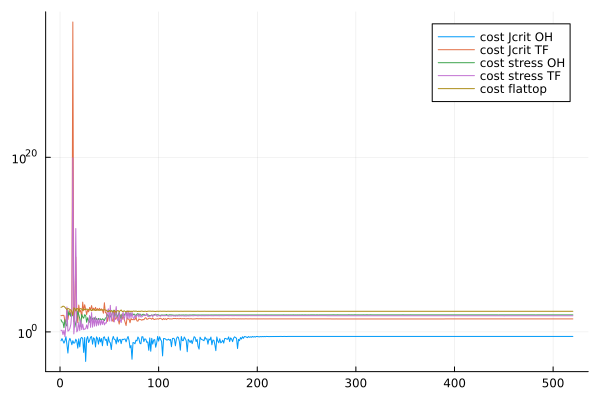

[PL.thickness] = [1.0300251178066788]
[OH.thickness, dd.build.oh.technology.fraction_steel] = [0.5107668250080366, 0.4308978300539505]
[TFhfs.thickness, dd.build.tf.technology.fraction_steel] = [0.11265925420069778, 0.6101416198523266]

target_B0 = 6.000020257639201
(dd.build.tf.max_b_field * TFhfs.end_radius) / R0 = 6.000020257639201

dd.build.oh.flattop_duration = 133053.42927233098
dd.requirements.flattop_duration = 172800.0

dd.build.oh.max_j = 4.319864662991345e7
dd.build.oh.critical_j = 6.460107064757915e7

dd.build.tf.max_j = 1.1480616421322149e8
dd.build.tf.critical_j = 1.358151132932106e8

maximum(dd.solid_mechanics.center_stack.stress.vonmises.oh) = 2.60794480344891e9
dd.solid_mechanics.center_stack.properties.yield_strength.oh = 8.0e8

maximum(dd.solid_mechanics.center_stack.stress.vonmises.tf) = 4.169436925456976e9
dd.solid_mechanics.center_stack.properties.yield_strength.tf = 8.0e8

old_R0 / a = 3.1105828312066435
R0 / a = 3.1105828312066435


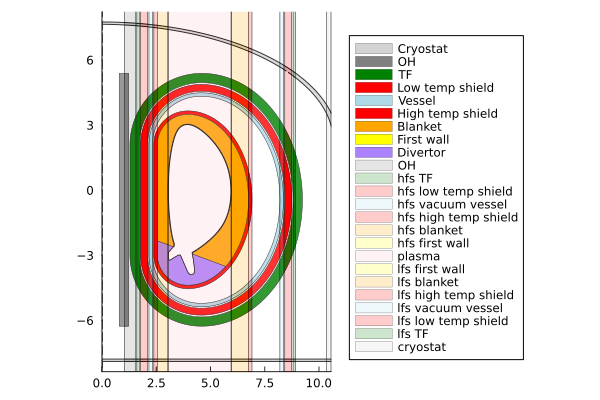

In [ ]:
FUSE.ActorHFSsizing(dd0, act);

## Digest

GEOMETRY                       EQUILIBRIUM                    TEMPERATURES                   DENSITIES                      
───────────────────────────    ───────────────────────────    ───────────────────────────    ───────────────────────────    
R0 → 4.5 [m]                   B0 → 6 [T]                     Te0 → 23.6 [keV]               ne0 → 2.05e+20 [m⁻³]           
a → 1.29 [m]                   ip → 8.87 [MA]                 Ti0 → 19.5 [keV]               ne_ped → 1.14e+20 [m⁻³]        
1/ϵ → 3.5 [m]                  q95 → 4.94                     <Te> → 9.92 [keV]              <ne> → 1.48e+20 [m⁻³]          
κ → 2.15                       <Bpol> → 0.823 [T]             <Ti> → 8.48 [keV]              ne0/<ne> → 1.39                
δ → 0.484                      βpol_MHD → 1.92                Te0/<Te> → 2.38                fGW → 0.992                    
ζ → -0.0617                    βtor_MHD → 0.0376              Ti0/<Ti> → 2.29                zeff_ped → 2                   


​


24×9 DataFrame
 Row │ group   details     type      ΔR         R_start   R_end     material      area       volume     
     │ String  String      String    Float64    Float64   Float64   String        Float64    Float64    
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ in                            1.03003     0.0       1.03003                 9.25785     23.1099
   2 │ in                  oh        0.510767    1.03003   1.54079  ReBCO          5.00345     31.7299
   3 │ in                            0.0642885   1.54079   1.60508                 0.74904      5.91194
   4 │ hfs                 tf        0.112659    1.60508   1.71774  ReBCO         13.1307     141.718
   5 │ hfs                           0.0642885   1.71774   1.78203                 1.96691     61.6187
   6 │ hfs     low temp    shield    0.318156    1.78203   2.10018  Steel          8.84237    276.772
   7 │ hfs                           0.0642885   2.10

​


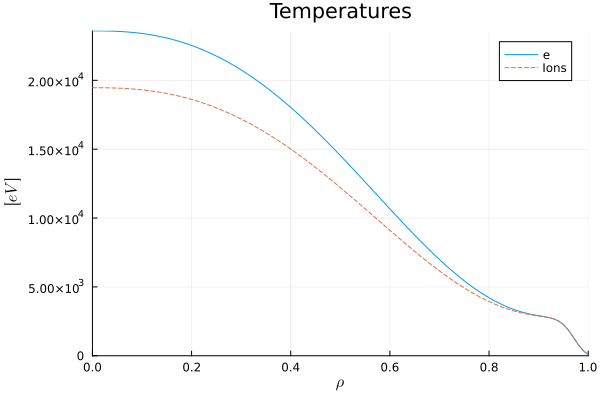

​


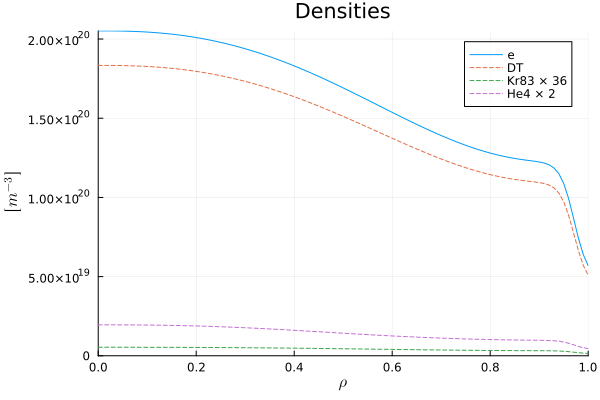

​


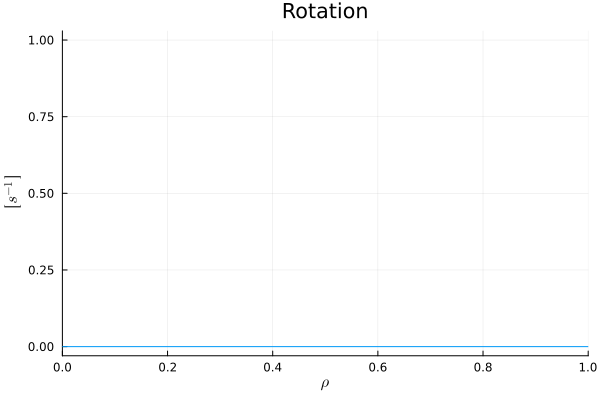

​


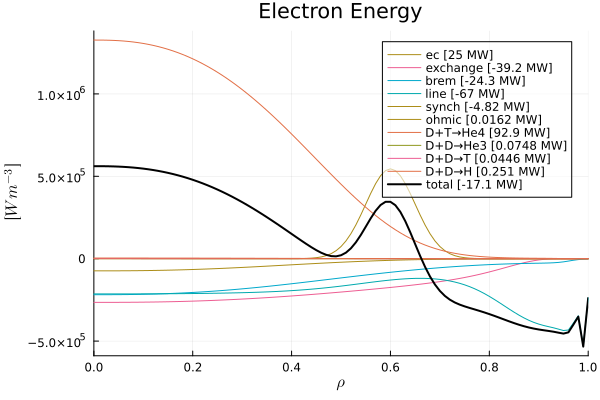

​


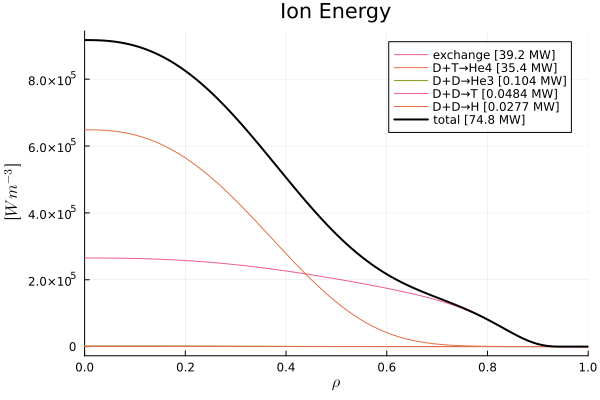

​


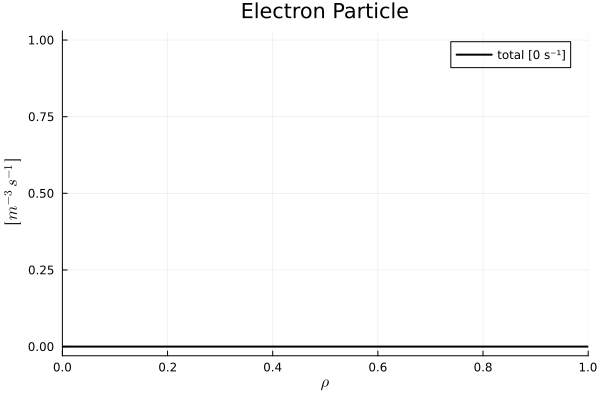

​


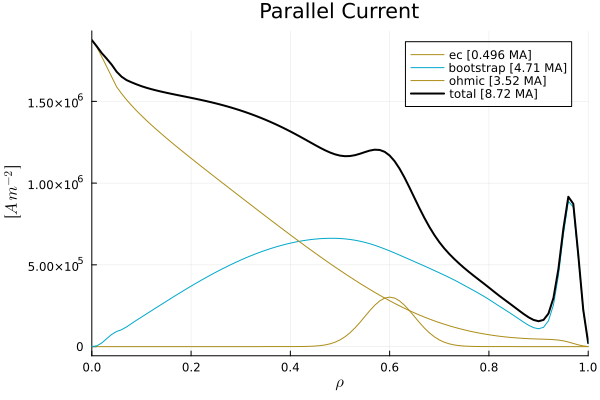

​


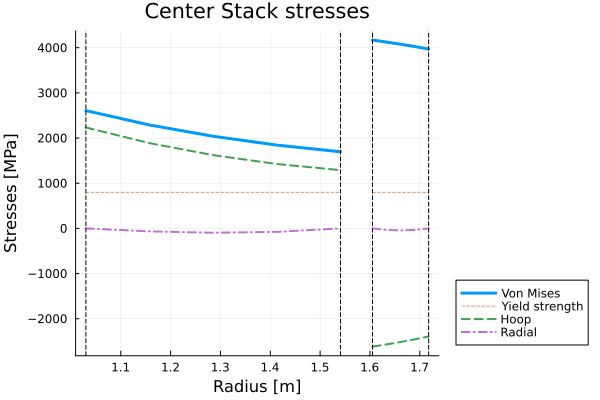

In [ ]:
FUSE.digest(dd0);